# Optimization Part 2

## Goal: 

Implement Batch Normalization (for each layer except the output layer)

## Experiment:  

Evaluate the expediency of training with and without Batch Normalization.  Data augmentation is used to create enough training data to make batch normalization meaningful



## Expected outcome:  

Batch Normalization should yield quicker convergence  (fewer training iterations) than networks trained without it.   
Note:  Because the network is randomly initialized (glorot) it is possible to have a bad starting condition which will make convergence difficult...several repetitions may be required to compare results of performance with an without batch normalization.  

In [1]:
import os
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

EPS = np.finfo(np.float32).eps  #minimum floating point number for numerical stability in calculations

In [2]:
#helper functions
DEBUG = True
def debug(*kargs):
    if DEBUG:
        print(*kargs)

### Defining the activation functions and their derivatives

In [3]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def dSigmoid(x):  # derivative of sigmoid
    s = sigmoid(x)
    return np.multiply(s, (1-s))


def relu(z):  # rectified linear unit activation
    return np.maximum(0, z)


def dRelu(z):
    """ 
    Derivative of Rectified Linear Unit

    """
    return 1 * (z > 0)


### ANN Class definition (contains layer class)

In [4]:
class ANN:
    data = []
    layers = []
    inputWidth = 1
    outputWidth = 1

    class Layer:

        """class defining the elements of an ANN layer"""

        @staticmethod
        def gradl2norm(weight_vals):
            """returns the gradient of the l2 norm with respect to the weights"""
            return weight_vals
    
        @staticmethod
        def gradl1norm(weight_vals):
            """returns the gradient of the l1 norm with respect to the weights"""
            return np.sign(weight_vals)

        @staticmethod
        def l2norm(vals):
            """returns the l2 norm of the vals"""
            return np.linalg.norm(vals,ord=2)
    
        @staticmethod
        def l1norm(vals):
            """returns the l1 norm of the vals"""
            return np.linalg.norm(vals,ord=1)
        
        def __init__(self):
            self.w = []
            self.b = []
            self.lam = 0  #for weight regularization
            self.weightRegFunction = self.l2norm  #placeholder for regularization function
            self.weightRegGradFunction = self.gradl2norm   #placeholder for regularization function
            self.batchNormalization = False  #batchNormalization for backpropagation
            self.vel_w=[] # for standard momentum of weight gradients
            self.vel_b=[] # for standard momentum of bias gradients
            self.nodecount = []
            self.activation_fcn = []
            self.activation_fcn_derivative = []
            self.orderNumber = []
            self.previous = None  # link to previous layer
            self.next = None  # link to next layer
            

        def set_weights(self, w, b):
            """set the weights and bias for the layer.  Layer weights should have dimesion: (thislayer_nodecount, previouslayer_nodecount)
            the dimension of the bias should be (thislayer_nodecount,1)"""
            self.w = w
            self.b = b
            return self
        
        def initialize_weights(self, glorot=False, seed=None ):
            assert self.w.size > 0
            assert self.b.size > 0
            np.random.seed(seed)

            #set biases 
            self.b = np.ones(self.b.shape)  #  biases (column vector of 1s)
            if self.activation_fcn == relu:
                self.b = self.b * 0.1  #for relu
            else:
                self.b = self.b * 0.0  # for sigmoid

            # set wieghts    
            if glorot:  #use glorot initialization
                n = self.w.shape[0]
                m = self.w.shape[1]
                self.w = np.zeros(self.w.shape)   #placeholder
                # compute the edges of the glorot-specified uniform distribution and then set self.w to a uniform dist
                # note: use np.random.uniform(loweredge,upperedge,size)
                u_edge = np.sqrt(6/(m+n))
                self.w = np.random.uniform(low=-u_edge,high=u_edge,size=(self.w.shape))
            else:
                self.w = np.random.normal(size=(self.w.shape))  # hidden weight matrix [rows = to, columns = from]
            
        def initialize_velocity(self):
            assert self.w.size > 0
            assert self.b.size > 0
            self.vel_w = np.zeros(self.w.shape)  # same shape as hidden weight matrix [rows = to, columns = from]
            self.vel_b = np.zeros(self.b.shape)  # same shape as hidden biases (column vector)
        

        def set_lambda(self, lam):
            self.lam = lam

        def set_weightRegFunction(self, fcn, d_fcn):
            self.weightRegFunction = fcn
            self.weightRegGradFunction = d_fcn
            
        def set_activation(self, activation_fcn):
            self.activation_fcn = activation_fcn
            return self

        def set_activation_deriv(self, activation_fcn):
            if activation_fcn == sigmoid:
                self.activation_fcn_derivative = copy.deepcopy(dSigmoid)
            elif activation_fcn == relu:
                self.activation_fcn_derivative = copy.deepcopy(dRelu)
            else:
                self.activation_fcn_derivative = None
                
        def display_params(self):
            """displays the weights and biases of the layer (rows = to, colums = from)"""
            for outNum in range(self.w.shape[0]):
                print(self.w[outNum,:], "  ", self.b[outNum], "  BatchNorm=", self.batchNormalization)
        

        def compute_pre_activation(self, inputs):
            net = np.dot(self.w, inputs) + self.b
            return net

        def compute_bias_gradient(self, gradient):
            g = np.mean(gradient, axis=1)[:, np.newaxis]  # no regularization
            return g

        def compute_weight_gradient(self, inputs, gradient):
            g = np.dot(gradient, inputs.T)
            g = g/inputs.shape[1]   #divide by m (batchsize)
            return g

        def compute_activation(self, net):
            return self.activation_fcn(net)

        def compute_activation_derivative(self, net):
            return self.activation_fcn_derivative(net)

        def compute_activation_gradient(self, net, gradient):
            g = np.multiply(gradient, net)
            return g

        def compute_forward(self, inputs):
            """Returns layer ouput from input (shape = [nodeCount, input]) of the weighted input plus bias
            input shape must be [lastlayer_nodeCount, samples] or [featurecount, samplecount] """
            net = self.compute_pre_activation(self, inputs)
            layer_out = self.compute_activation(net)
            return layer_out


        def regularization_grad_weights(self,vals):
            """computes the regularization cost for the current layer weights"""
            mylam = self.lam
            myregs = self.weightRegGradFunction(vals)
            return mylam*myregs
        
        
        def compute_layer_gradients(self, net, activation, gradient):
            """ computes the loss gradient with respect to desired output of the layer
            a set of desired targets is assumed to be matrix of shape [nodecount, samples]: SGD will have [nodecount,1]
            hidden_inputs is assumed to be a matrix of shape [hiddenNodeCount, samples]
            
            This follows algorithm 6.4 line by line in the book!
            
            """
            
            # f'(a(k))
            d_activation = self.compute_activation_derivative(net)  # derivative of sigmoid:  shape = [NodeCount, samples]
            
            # g <- g * f'(a(k))
            g_loss = self.compute_activation_gradient(d_activation, gradient)  # shape = [NodeCount, samples]  for outer layer
            
            # Delta_b(k) J = g (Take the mean across all 4 samples (batch))
            g_loss_b = self.compute_bias_gradient(g_loss)  # mean gradient with respect to BIAS, shape = [NodeCount, 1]
            
            # Delta w(k) J = g * h(k-1) +lam*regularizationGrad w.r.t weights
            if self.batchNormalization == False:
                g_loss_w = self.compute_weight_gradient(activation, g_loss) + self.regularization_grad_weights(self.w) # [thisLayerNodecount,prevLayerOutputcount]  
                #NOTE - regularization grad weights NOT WORKING YET
            else: #use batch normalization
                n_activation = self.normalize_activation(activation)
                #debug("--normalized activation shape:", n_activation.shape)
                g_loss_w = self.compute_weight_gradient(n_activation, g_loss) + self.regularization_grad_weights(self.w) # [thisLayerNodecount,prevLayerOutputcount]  
                
            
            # g <- W(k).T * g
            g_loss_backprop = np.dot(self.w.T, g_loss)  # gradient to propagate back, shape = [hiddenNodeCount,samples]
            
            return g_loss_w, g_loss_b, g_loss_backprop

        def update_Layer(self, weightUpdate, biasUpdate, momentum=0):
            """Update weights and biases. weightUpdate is shape [thisLayerNodecount,prevLayerOutputcount]; biasUpdate is shape [thisLayerNodecount,1]"""
            if momentum == 0:  #note this if-else statement not required if written as math eq with momentum & velocity >> more efficient!
                self.w = self.w + weightUpdate
                self.b = self.b + biasUpdate
            else:  #note this if-else statement not required if written as math eq with momentum & velocity
                # need to compute the new values for self.w and self.b using momentum
                # note: momentum is passed in but velocity must be updated & stored in self.vel_w and self.vel_b
                self.vel_w = momentum*self.vel_w+weightUpdate
                self.vel_b = momentum*self.vel_b+biasUpdate
                self.w = self.w + self.vel_w
                self.b = self.b + self.vel_b


    def __init__(self):
        self.data = []
        self.layers = []
        self.inputWidth = 1
        self.outputWidth = 1
    
        
    def set_input_width(self, inputWidth):
        """defines the input layer width for the network"""
        self.inputWidth = inputWidth

    def add_layer(self, nodecount=1, activation_fcn=relu):
        """adds a layer to the neural network and returns the layer"""
        oldLayerCount = len(self.layers)
        thislayer = ANN.Layer()
        thislayer.orderNumber = oldLayerCount + 1
        if oldLayerCount > 0:  # other layers have been added already
            lastLayer = self.layers[-1]
            lastLayer.display_params()
            thislayer.previous = lastLayer
            lastLayer.next = thislayer
            layerInputSize = lastLayer.w.shape[0]
        else:  # this will be the first layer
            layerInputSize = self.inputWidth
            
        thislayer.w = np.zeros((nodecount, layerInputSize))  #[NODECOUNT,FROM]
        thislayer.b = np.zeros((nodecount, 1 )) #[NODECOUNT,FROM]
        thislayer.vel_w = np.zeros(thislayer.w.shape)  # same shape as hidden weight matrix [rows = to, columns = from]
        thislayer.vel_b = np.zeros(thislayer.b.shape)  # same shape as hidden biases (column vector)

        thislayer.activation_fcn = activation_fcn
        thislayer.set_activation_deriv(activation_fcn)
        self.outputWidth = nodecount
        self.layers = self.layers + [thislayer]
        return thislayer
    
    def initialize(self, **kwargs):
        """initialize weights & biases & velocity: overwrites current network parameters
        default parameters: glorot = False, batchNormalization=False, seed = None
        """

        #defaults
        glorot = False
        batchNormalization = False
        seed = None
        #extract optional parameters from **kwargs and replace defaults
       	attributes = {k:v for k,v in kwargs.items() if v}
        glorot =  attributes.get('glorot',False)
        batchNormalization =  attributes.get('batchNormalization',False)
        seed= attributes.get('seed',None)
        #conduct the initialization
        lastLayer = len(self.layers)-1
        for lnum, layer in enumerate(self.layers):
            layer.initialize_weights(glorot=glorot, seed=seed)
            layer.initialize_velocity()
            if lnum<lastLayer:
                layer.batchNormalization = batchNormalization  # all layers except the output layer will have this True or False initialized
            
    def set_batchNormalization(self, batchNormalization=False):
        """set the batch normalization (True or False) for all the network layers"""
        lastLayer = len(self.layers)-1
        for lnum, layer in enumerate(self.layers):
            if lnum<lastLayer:
                layer.batchNormalization = batchNormalization  # all layers except the output layer will have this True or False when called
            
    def setL1weightNormalization(self,lam=0):
        for idx,layer in enumerate(self.layers):
            layer.set_lambda(lam)
            layer.set_weightRegFunction(layer.l1norm,layer.gradl1norm)
            print(" Set Layer ", idx," weightNorm to gradl1norm with lambda = ", lam)
            

    def setL2weightNormalization(self,lam=0):
        for idx,layer in enumerate(self.layers):
            layer.set_lambda(lam)
            layer.set_weightRegFunction(layer.l2norm,layer.gradl2norm )
            print(" Set Layer ", idx," weightNorm to gradl2norm with lambda = ", lam)

            
    def summary(self):
        """displays a summary of the model"""
        tot_train_parameters = 0
        print("\n")
        print("Layer     Inshape     Outshape     Param #     LambdaReg")
        print("==========================================================")
        for lnum, layer in enumerate(self.layers):
            inshape = layer.w.shape[1]
            weightCount = layer.w.shape[0]*layer.w.shape[1]  #assume fully connected
            biasCount = layer.b.shape[0]
            thislayerparams = weightCount+biasCount
            tot_train_parameters += thislayerparams
            lam = layer.lam
            print("% 3d       % 3d         % 3d         %3d         %3f" %(lnum,inshape,biasCount,thislayerparams,lam))
        print("==========================================================")
        print("total trainable params: ",tot_train_parameters )
        
    def display_params(self):
        """displays the weights and biases of the network (rows = to, colums = from)"""
        print("\n")
        print("input width: ", self.inputWidth)
        for lnum, layer in enumerate(self.layers):
            print("Layer ",lnum)
            layer.display_params()
        print("output width: ", layer.w.shape[0])
                
                
    def forwardPropagation(self, inputs):
        """Compute forward pass of two layer network
        inputs are assumed to be (shape=[sampleCount,featureCount])
        returns a matrix of raw outputs with one row of output per node (shape=[sampleCount, outputNodeCount])
        Internal matrices are shaped for efficiency to avoid internal transposes (columns hold observations/samples) """

        # inputs and outputs will be transposed for efficiency during forwardPropagation and untransposed before returning

        nets = []
        activations = []
        layer_input = inputs.T

        for lnum, layer in enumerate(self.layers):
            # inputs = inputs + inputs
            layer_net = layer.compute_pre_activation(layer_input)
            nets.append(layer_net)

            layer_out = layer.compute_activation(layer_net)
            activations.append(layer_out)

            layer_input = layer_out
        raw_output = layer_out.T
        return raw_output, inputs, nets, activations

    def backPropagation(self, inputs, desiredOutputs, learningRate, momentum=0):
        w_grads = []
        b_grads = []
        # store nets and activations for each layer
        raw_output, _, nets, activations = self.forwardPropagation(inputs)
        layer_desired_out = desiredOutputs

        # Note: This is only part of the gradient
        layer_grad = desiredOutputs - raw_output
        layer_grad = layer_grad.T  #in order to match expectation for last layer output
        prev_layer_outputs = [inputs.T] + activations  #insert inputs onto activation stream for easy computations

        #  computation of full gradient handled inside the loop below
        for lnum, layer in reversed(list(enumerate(self.layers))):
            #get the input to this layer
            curr_layer_input=prev_layer_outputs[lnum]
            #get the gradients for the layer    
            w_grad, b_grad, loss_grad = layer.compute_layer_gradients(nets[lnum], curr_layer_input, layer_grad)    

            layer.update_Layer(w_grad * learningRate, b_grad * learningRate, momentum=momentum)
            layer_grad = loss_grad

    def predict(self, X, threshold=0.5):
        """Compute predictions using forward propagation for single binary classification at threshold
        X is a standard dataFrame without biases (shape=[observationCount,featureCount])
        returns a standard column vector of binary predictions in {0,1}: (shape=[observationCount, 1])"""
        raw_predictions, net_inputs, net_lst, activation_lst = self.forwardPropagation(X)
        preds = raw_predictions > threshold
        return preds


    def compute_loss(self, raw_outputs, desired_targets):
        """
        computes the (scalar) loss using Binary Cross Entropy of a set raw ouputs and desired targets 
        raw_outputs and desired_targets are assumed to be arrays of shape [samples, 1]
        """
        y = desired_targets
        bce = -np.mean( (y*np.log(raw_outputs+EPS)) + ((1-y)*np.log(1-raw_outputs+EPS)) )
        #using EPS to prevent log(0) numerical problems
        return bce



    def fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
            batchsize = 1, momentum=0, valPatience=0, tolerance=1e-2, maxEpochs = 100, verbose = True):
        """fit model to map tngInputs to tngTargets. If valPatience > 0 then use early stopping on valInputs & valTargets
        returns training loss history and val loss history """
        done = False
        best_model_so_far = self  #store existing model

        tng_loss_history = []
        val_loss_history = []
        if verbose:
            print("Training Model...")
        epoch = 0
        #get current tng performance
        tng_out_raw, _, _, _ = self.forwardPropagation(tngInputs)
        tngPreds = self.predict(tngInputs)
        tngCorrect = tngTargets == tngPreds
        curr_train_loss = self.compute_loss(tng_out_raw, tngTargets).item()
        tng_loss_history.append(curr_train_loss)

        #get current val performance
        val_out_raw, _, _, _ = self.forwardPropagation(valInputs)
        valPreds = self.predict(valInputs)
        prev_val_loss = self.compute_loss(val_out_raw, valTargets).item()
        val_loss_history.append(prev_val_loss)
        val_epochs_nonimproved = 0
        training_count = tngInputs.shape[0]
        if batchsize>training_count: batchsize=training_count #prevent sampling beyond training size

        
        while not done:
            epoch+=1
            if epoch>maxEpochs: 
                done = True
            learningRate = learningRate * learningRateDecay
            #eval training performance
            tng_out_raw, _, _, _ = self.forwardPropagation(tngInputs)
            tngPreds = self.predict(tngInputs)
            tngCorrect = tngTargets == tngPreds
            curr_train_loss = self.compute_loss(tng_out_raw, tngTargets).item()
            tng_loss_history.append(curr_train_loss)
            #evaluate validation performance
            val_out_raw, _, _, _ = self.forwardPropagation(valInputs)
            valPreds = self.predict(valInputs)
            cur_val_loss = self.compute_loss(val_out_raw, valTargets).item()

            if cur_val_loss < tolerance:  #regular stopping
                done = True
                if verbose:
                    print(" --- Regular Stopping due to val loss < tolerance; val loss:", cur_val_loss)
                break
            
            # run an epoch of backprop
            #shuffle the indexes of the inputs & targets simultaneously
            order=np.random.permutation(training_count)
            #debug("range check ", np.arange(training_count))
            #debug("tng count:", training_count, ";   tng index order: ", order)
            first_tng_index=0
            last_tng_index = batchsize
            
            tinp = tngInputs[order]
            ttar = tngTargets[order]
            
            while last_tng_index<=training_count:
                #get a batch
                batchIn = tinp[first_tng_index:last_tng_index,:]
                batchTar = ttar[first_tng_index:last_tng_index,:]
                #train on the batch using backprop
                self.backPropagation(batchIn, batchTar, learningRate=learningRate, momentum=momentum)
                first_tng_index+=batchsize
                last_tng_index+=batchsize
                #handle mis-aligned training set sizes
                if first_tng_index < training_count-1 and last_tng_index>training_count-1:
                    batchIn=tinp[first_tng_index:training_count,:]
                    batchTar=ttar[first_tng_index:training_count,:]
                    self.backPropagation(batchIn, batchTar, learningRate=learningRate, momentum=momentum)
            

            # Early Stopping via VAL loss improvement
            # if validation loss has not improved in patience epochs then stop
            if cur_val_loss < prev_val_loss:
                val_epochs_nonimproved = 0
                prev_val_loss = cur_val_loss
            else:
                val_epochs_nonimproved+=1
                if valPatience > 0 and val_epochs_nonimproved > valPatience :
                    if verbose:
                        print(" --- EARLY STOPPING ACTIVATED AT val_epochs_nonimproved =  ",val_epochs_nonimproved)
                    done=True

            val_loss_history.append(cur_val_loss)
            
        if verbose:
            print("Training Complete!")

        return tng_loss_history, val_loss_history    
    


# Student Coding steps:

 Implement Batch Normalization for backprop in Layer inner class function ```normalize_activation(self, activation)normalize_activation(self, activation)```
 
 The equations are
 
1. Compute the mean of the activation values: 
$$\mu=\frac{1}{m}\sum_{i}{}H_{i,:}$$
2. Compute the standard deviation of the activation values: 
$$\sigma=\sqrt{\delta+\frac{1}{m}\sum_{i}{}(H-\mu)^2_i}$$
3. Compute the mean of the normalized activation values 
$$H'=\frac{H-\mu}{\sigma}$$

where several values are already provided for you: 
$\delta$ is a small numerical adjustment to prevent undefined gradients (10e-8)
$m$ is the batch size (observation count being used) accessible via ```activation.shape[1]activation.shape[1]```




In [16]:
class ANN(ANN):
    data = []
    layers = []
    inputWidth = 1
    outputWidth = 1

    class Layer(ANN.Layer):
        
        def normalize_activation(self, activation):
            """Implements batch normalization upon a set of activations by computing and returning
            normalized activations for use in batch normalization computations"""
            
            
            batchsize = activation.shape[1]  # this is quantity "m" in the equations
            nodecount = activation.shape[0]  # this is the number of nodes in the layer
            delta = 10e-8
            
            #set up placeholders that you will compute in the student code area below
            activation_mu = np.zeros(shape=(activation.shape[0],1)) #placeholder must be shape ([nodecount, 1])
            activation_sigma = np.ones(shape=(activation.shape[0],1)) #placeholder must be shape ([nodecount, 1])
            activation_norm = activation #placholder must be same shape as activation ([nodecount, batchsize])
           
            ############### STUDENT CODE FOR BATCH NORMALIZATION ###############
           
            # IMPLEMENT EQUATION 1
            #compute the mean of the activation: activation_mu (shape=[nodecount, 1]) : a column vector
            # note that there will be 1 mean per node:  it is taken across the observations
            activation_mu = np.mean(activation, axis=1, keepdims=True)
            #activation_mu = np.sum(activation, axis=1)/batchsize

            # IMPLEMENT EQUATION 2
            # compute the sigma of the activation (shape=[nodecount, 1]): a column vector
            # caution: there should be 1 std_dev per node:  it is the std_dev of the observations' activation at that node

            # subtract the activation_mu from the activation matrix; must be same shape as activation
            # hint, use np.subtract() to broadcast
            
            residuals = activation-activation_mu
            activation_sigma = np.sqrt(delta + (residuals@residuals.T)/batchsize)

            #compute new normalized activations h_prime from original activation ([nodecount, batchsize])
            
            activation_norm = residuals/activation_sigma
            
            ########################## END STUDENT CODE ########################
            
            assert(activation_norm.shape==(nodecount,batchsize))  #test to ensure return value shape is correct
            
            return activation_norm  #must be of shape [nodecount,batchsize]


---

### Helper function to produce datasets for logic gates

In [17]:
def get_input_output_data(gate='XOR'):
    """ Two dimensional inputs for logic gates

    Parameters
    ----------
    gate : str
        Must be either AND, OR, XOR

    Returns
    -------
    X : array-like, shape(samples, features)
        Two dim input for logic gates

    truth[gate] : array-like, shapes(samples, )
        The truth value for this logic gate

    """

    X = np.array([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

    truth = {
        'AND': np.array([0, 0, 0, 1]),
        'OR': np.array([0, 1, 1, 1]),
        'XOR': np.array([0, 1, 1, 0])
    }

    return X, truth[gate][:, np.newaxis]

## Helper function to create augmented data for Boolean logic problems

In [18]:
def generateAugmentedTrainData(X,Y,augscale=0.0, augCount=100, seed = None):
    """starting with original datapoints X and labels Y, return new augmented datapoints of size augCount"""
    np.random.seed(seed=seed)
    xtrain = X #placeholder only
    ytrain = Y #placeholder only
    

    # make a larger dataset in which you add a small random perturbation to the features of each datapoint
    
    xtrain = []  #placeholder - will be filled with quantity augCount observations of the original observation shape of X
    ytrain = []  #placeholder - will be filled with quantity augCount observations of the original label shape of Y
    
    idx = np.random.randint(X.shape[0], size=augCount)
    noise = np.random.uniform(low=-0.5, high=0.5, size = (augCount,X.shape[1]))
    xtrain = X[idx]+noise
    ytrain = Y[idx]
    
    
    return xtrain,ytrain

## Helper functions - Visualization

For displaying graphical output

In [19]:
def dataplotter(featureData, labelData, title):
    '''plot annotated points to show where the boolean inputs lie on the graph''' 

    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

        
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()
    




def makeDecisionBoundaryBool2(model, featureData, labelData, title):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''
    cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = model.predict(grid)  # get predictions
    z = preds.reshape(X.shape) > cutoff  # cutoff on predictions to return boolean output
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()


def show2dFunctionOutput(model_function, featureData, labelData, title):
    """display results of arbitrary model function on 2-input (x1,x2) , 1-output (z) graphs"""
    # cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots(figsize=(8,5))

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    outputs, _, _, _ = model_function(grid)  # get predictions
    z = outputs.reshape(X.shape)  # reshape predictions for 2d representation
    plotlevels = np.linspace(0.,1., 25)  # split colors between 0 and 1
    CS = plt.contourf(X, Y, z, levels = plotlevels, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

    
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('raw network output')
    # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')

    plt.title(title)
    plt.show()
    
def showLossHistory(tng_loss_history=[],val_loss_history=[],semilog=True,plotname=""):
    plt.figure()
    if semilog:
        plt.semilogy(tng_loss_history,'r', label = "Training Loss")
        plt.semilogy(val_loss_history, 'b', label = "Validation Loss")
        plt.ylabel("Loss (BCE) - semilog scale")

    else:    
        plt.plot(tng_loss_history,'r', label = "Training Loss")
        plt.plot(val_loss_history, 'b', label = "Validation Loss")
        plt.ylabel("Loss (BCE)")
    plt.xlabel("iteration")
    plt.legend()
    plt.title(plotname+" Loss over iterations")
    plt.show() 
    

### Helper function to *instantiate* an ANN model from parameters

In [20]:
def make_ANN_model(input_width = 2,
                   layer_widths = [2,1],
                   layer_activiations = [sigmoid,sigmoid],
                   batchNormalization = False,
                  glorot = False):
    model = ANN()
    print(list(zip(layer_widths,layer_activiations)))
    model.set_input_width(input_width)
    for lnum,(layerWidth,layerActivation) in enumerate(zip(layer_widths,layer_activiations)):
        model.add_layer(nodecount = layerWidth, activation_fcn=layerActivation)
    model.initialize(glorot=glorot, batchNormalization=batchNormalization)
    return model
        
 
    
    

---

### Helper function to *train* an ANN from parameters.  Allows for separate training and validation data

In [21]:
def train_ANN_model(model=None,
                    trainX = None, trainY = None,
                    valX=None,valY=None,
                    learning_rate=1.0,
                    lr_decay=0.999,
                    batchsize = 1,
                    momentum = 0,
                    valPatience=0,
                    maxEpochs = 100,
                    verbose = True,
                    showgraphs = True,
                    modelTitle = ""):
    
    

    preds = model.predict(valX)
    correct = valY == preds
    if verbose:
        textToPrint = modelTitle + " BEFORE TRAINING (randomized weights)"
        print(textToPrint)
        model.display_params()
        
    tng_loss_history,val_loss_history = model.fit(tngInputs=trainX, tngTargets=trainY, valInputs=valX, valTargets = valY,
                                                  learningRate=learning_rate, learningRateDecay=lr_decay, batchsize=batchsize,
                                                  momentum = momentum, valPatience=valPatience,
                                                  tolerance=1e-1, maxEpochs=maxEpochs, verbose=verbose)

    preds = model.predict(valX)
    correct = valY == preds

    if verbose:
        textToPrint = modelTitle + " AFTER TRAINING (learned model weights)"
        print(textToPrint)
        model.display_params()

    if showgraphs:
        show2dFunctionOutput(model.forwardPropagation, X, Y, modelTitle + " Raw Response of Network")
        makeDecisionBoundaryBool2(model, X, Y, modelTitle + " XOR predictions from Network")
        showLossHistory(tng_loss_history,val_loss_history, modelTitle + " Loss over Iterations")

    return model, tng_loss_history,val_loss_history


## Model instantiation

Create and initialize a fully connected network.  We will create the network first with batch normalization turned off, then make a copy (with the randomly instantiated weights) and turn batch normalization on.  That will allow us to compare performance from the same initialization point.

In [22]:
LAYER_WIDTHS = [2,1]  #number of nodes in each layer
LAYER_ACTIVATIONS = [sigmoid,sigmoid]

model = make_ANN_model(input_width = 2,
                       layer_widths = LAYER_WIDTHS,  #number of nodes in each layer
                       layer_activiations = LAYER_ACTIVATIONS,
                       batchNormalization=False,
                       glorot=True)  #activations at each layer

print("=====Empty model info (BN=False)=====")
model.summary()
model.display_params()

#Make a copy of this model with the same initialization so we can do batch norm = true but start from the same point

model_bn = copy.deepcopy(model)
model_bn.set_batchNormalization(True)
print("\n=====Empty model info (BN=True)=====")
model_bn.summary()
model_bn.display_params()


[(2, <function sigmoid at 0x7fcbf0f6b550>), (1, <function sigmoid at 0x7fcbf0f6b550>)]
[0. 0.]    [0.]   BatchNorm= False
[0. 0.]    [0.]   BatchNorm= False
=====Empty model info (BN=False)=====


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9


input width:  2
Layer  0
[ 0.18831136 -1.06309824]    [0.]   BatchNorm= False
[-0.93930196  1.13421301]    [0.]   BatchNorm= False
Layer  1
[0.71296005 0.060961  ]    [0.]   BatchNorm= False
output width:  1

=====Empty model info (BN=True)=====


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9


input width:  2
Layer  0
[ 0.18831136 -1.06309824]    [0.]   BatchNorm= True
[-0.93930196  1.13421301]    [0.]   BatchNorm= True
Layer  1
[0.71296005 0.060961  ]  

### Generate the XOR problem dataset and the augmented data for training

In [23]:
X, Y = get_input_output_data(gate='XOR')
DATA_AUGMENT_SEED=42
x_augmented,y_augmented = generateAugmentedTrainData(X,Y,augscale=0.1,augCount=128, seed = DATA_AUGMENT_SEED)  #save these augmented for later

#use only the augmented data for training
trainX = x_augmented
trainY = y_augmented

valX = X
valY = Y

In [24]:
### Set training parameters

In [25]:
BATCHSIZE = 16  #set up a batchsize for both with and without BN; make sure it is large enough to allow BN to make good estimates
VALPATIENCE = 200  #set to zero to run until model fits well to loss; set > 0 to activate early stopping if no improvement by VALPATIENCE value

### Train a model without BatchNormalization

 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 0.18831136 -1.06309824]    [0.]   BatchNorm= False
[-0.93930196  1.13421301]    [0.]   BatchNorm= False
Layer  1
[0.71296005 0.060961  ]    [0.]   BatchNorm= False
output width:  1
Training Model...


 --- EARLY STOPPING ACTIVATED AT val_epochs_nonimproved =   201
Training Complete!
 AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[ 4.15765678 -4.2621209 ]    [-3.72861894]   BatchNorm= False
[-5.00703797  4.17590622]    [-1.61731793]   BatchNorm= False
Layer  1
[7.40848574 4.99998459]    [-2.76578545]   BatchNorm= False
output width:  1


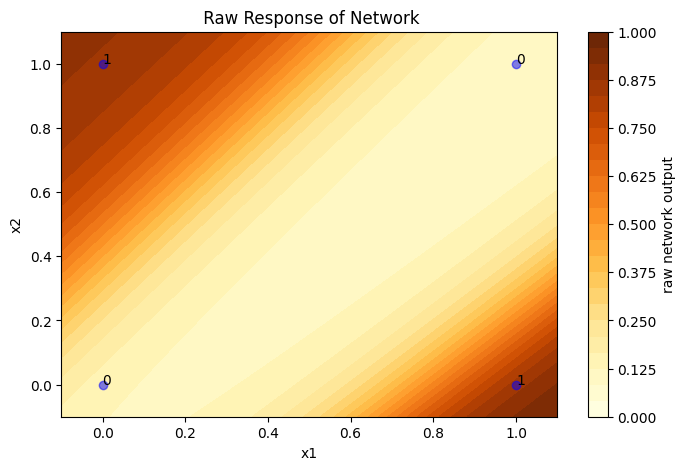

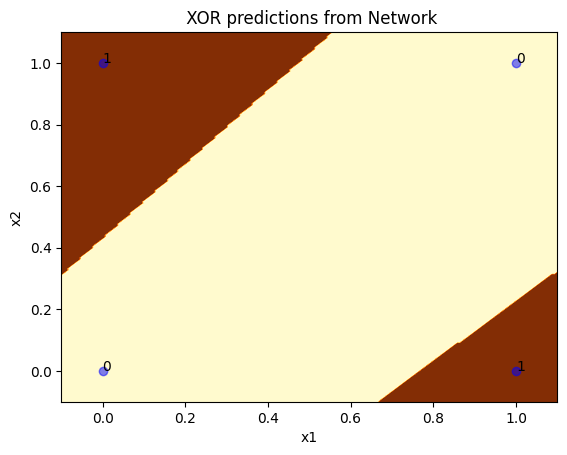

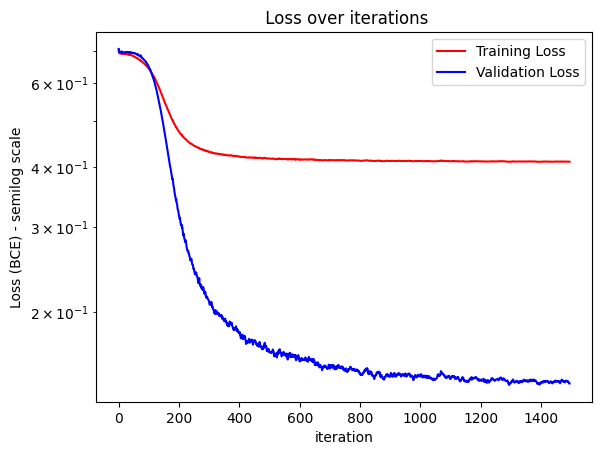

In [26]:
model_trained_noBN, tng_loss_history_noBN, val_loss_history_noBN = train_ANN_model(model,trainX,trainY,valX,valY,
                                                            learning_rate=1.0,lr_decay=0.999, batchsize=BATCHSIZE, 
                                                            momentum = 0, valPatience = VALPATIENCE, maxEpochs = 5000)

### Train a model with BatchNormalization

Note we are using a larger learning rate to start with here

In [27]:
model_trained_BN, tng_loss_history_BN, val_loss_history_BN =train_ANN_model(model_bn,trainX,trainY,valX,valY,
                learning_rate=10.0,lr_decay=0.999, batchsize=BATCHSIZE, 
                momentum = 0, valPatience = VALPATIENCE, maxEpochs = 5000)

 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 0.18831136 -1.06309824]    [0.]   BatchNorm= True
[-0.93930196  1.13421301]    [0.]   BatchNorm= True
Layer  1
[0.71296005 0.060961  ]    [0.]   BatchNorm= False
output width:  1
Training Model...


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 16)

Helper function to repeatedly train a model under similar conditions

Set up an experiment to compare performance between with and without batch norm

We will build a model with a single small architecture, and then explore its performance under repeated experiments with and without batchnormalization

In [ ]:
#build the model we will use
LAYER_WIDTHS = [2,1]  #number of nodes in each layer
LAYER_ACTIVATIONS = [sigmoid,sigmoid]

model = make_ANN_model(input_width = 2,
                       layer_widths = LAYER_WIDTHS,  #number of nodes in each layer
                       layer_activiations = LAYER_ACTIVATIONS,
                       batchNormalization=False,
                       glorot=True)  #activations at each layer

print("=====Empty model info (BN=False)=====")
model.summary()
model.display_params()

#Make a copy of this model with the same initialization so we can do batch norm = true but start from the same point

model_bn = copy.deepcopy(model)
model_bn.set_batchNormalization(True)
print("\n=====Empty model info (BN=True)=====")
model_bn.summary()
model_bn.display_params()




[(2, <function sigmoid at 0x7fcbf0f6b550>), (1, <function sigmoid at 0x7fcbf0f6b550>)]
[0. 0.]    [0.]   BatchNorm= False
[0. 0.]    [0.]   BatchNorm= False
=====Empty model info (BN=False)=====


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9


input width:  2
Layer  0
[-0.18616889  0.61690809]    [0.]   BatchNorm= False
[0.51511071 0.82516978]    [0.]   BatchNorm= False
Layer  1
[-1.30590353 -0.41142945]    [0.]   BatchNorm= False
output width:  1

=====Empty model info (BN=True)=====


Layer     Inshape     Outshape     Param #     LambdaReg
  0         2           2           6         0.000000
  1         2           1           3         0.000000
total trainable params:  9


input width:  2
Layer  0
[-0.18616889  0.61690809]    [0.]   BatchNorm= True
[0.51511071 0.82516978]    [0.]   BatchNorm= True
Layer  1
[-1.30590353 -0.41142945]  

In [ ]:

def repeat_model_eval(model, train_function_params, batchnorm=False, reps = 1, progress_reporting=True):
    ''' Repeatedly instantiate and fit a model multiple times and report results
    params:
    model_params:  parameters to pass to the model instantiation function (make_ANN_model())
    train_function_params:  parameters to pass to the 
    '''
    totalCorrect = 0
    countPerfectVal = 0
    epochCountVector = np.zeros(reps)
    totalEpochCount = 0
    print("running "+str(reps)+" iterations:")
    
    for idx in range(reps):

        model.initialize(batchnorm=batchnorm)
        model.set_batchNormalization(batchnorm)

        model,tng_loss_history,val_loss_history= train_ANN_model(model,**train_function_params)

        preds = model.predict(valX)
        correct = valY == preds
        totalCorrect=totalCorrect+correct
        final_val_loss = round(val_loss_history[-1], 4)
        countPerfectVal = countPerfectVal+(sum(correct)==4)
        epochCount = len(val_loss_history)
        epochCountVector[idx]=epochCount
        totalEpochCount=totalEpochCount+epochCount
        if progress_reporting:
            print(idx, end=": ")
            print("epoch count: "+str(epochCount), end = "; ")
            print("val loss: " +str(final_val_loss), end="; ")
            print("val preds correct: "+str(sum(correct).item()))

    correctness = round(sum(totalCorrect).item()/(reps*4),4)
    
    avgEpochCount = round(totalEpochCount/reps,2)
    medianEpochCount = np.median(epochCountVector)
    
    print("\n"+str(reps)+
          "x reps:  "+
          " medianEpochCount = "+
          str(medianEpochCount)+
          ", Correctness = "+
          str(correctness)+
          ", Perfect Count = "+str(countPerfectVal.item()))
    return medianEpochCount,correctness,countPerfectVal.item()

In [ ]:
REPS = 10

MOMENTUM = 0  #value 0 to less than 1.   Too high overshoots!
LEARNING_RATE_REGULAR = 1.0
LEARNING_RATE_BATCHNORM = 10.0
LEARNING_RATE_AGGRESSIVE = 50.0
LEARNING_RATE=LEARNING_RATE_BATCHNORM

BATCHSIZE = 32  #set up a batchsize for both with and without BN; make sure it is large enough to allow BN to make good estimates
VALPATIENCE = 200  #set to zero to run until model fits well to loss; set > 0 to activate early stopping if no improvement by VALPATIENCE value
LR_DECAY = 0.999



train_function_params = {
    'trainX':trainX,'trainY':trainY,'valX':valX,'valY':valY,
    'learning_rate':LEARNING_RATE,
    'lr_decay':LR_DECAY,
    'batchsize':BATCHSIZE,
    'momentum' : MOMENTUM,
    'valPatience' : VALPATIENCE,
    'maxEpochs' : 5000,
    'verbose' : False,
    'showgraphs':False}

train_function_params_BN = {
    'trainX':trainX,'trainY':trainY,'valX':valX,'valY':valY,
    'learning_rate':LEARNING_RATE,
    'lr_decay':LR_DECAY,
    'batchsize':BATCHSIZE,
    'momentum' : MOMENTUM,
    'valPatience' : VALPATIENCE,
    'maxEpochs' : 5000,
    'verbose' : False,
    'showgraphs':False}


print("-------Training model without batchnorm")
repeat_model_eval(model =model ,train_function_params = train_function_params , reps = REPS )

print("\n\n\n-------Training model with batchnorm")
repeat_model_eval(model =model_bn ,train_function_params = train_function_params , batchnorm=True, reps = REPS )



-------Training model without batchnorm
running 10 iterations:
0: epoch count: 138; val loss: 0.1061; val preds correct: 4
1: epoch count: 87; val loss: 0.1024; val preds correct: 4
2: epoch count: 629; val loss: 0.1307; val preds correct: 4
3: epoch count: 512; val loss: 0.1307; val preds correct: 4
4: epoch count: 116; val loss: 0.1041; val preds correct: 4
5: epoch count: 688; val loss: 0.1286; val preds correct: 4
6: epoch count: 1080; val loss: 0.3527; val preds correct: 3
7: epoch count: 874; val loss: 0.3497; val preds correct: 3
8: epoch count: 719; val loss: 0.1331; val preds correct: 4
9: epoch count: 575; val loss: 0.134; val preds correct: 4

10x reps:   medianEpochCount = 602.0, Correctness = 0.95, Perfect Count = 8



-------Training model with batchnorm
running 10 iterations:
0: epoch count: 1037; val loss: 0.1244; val preds correct: 4
1: epoch count: 458; val loss: 0.1344; val preds correct: 4
2: epoch count: 114; val loss: 0.1073; val preds correct: 4
3: epoch count: 8

(286.0, 0.975, 9)

## Optional:   use the models and training history to explore performance of training with and without batch normalization

In [ ]:
#model_trained_BN, tng_loss_history_BN, val_loss_history_BN
#model_trained_noBN, tng_loss_history_noBN, val_loss_history_noBN